# Greedy layer-wise AE and VAE for tomographies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import numpy as np
import glob
from PIL import Image

In [2]:
# get files list
files = (glob.glob('Coll*/data/*/*/*/Pr*/*rec.tif'))
len(files)

31

In [3]:
# get all image arrays
Xs = []
for file in files:
    im = io.imread(file)
    Xs.append(im)

In [4]:
# size of image to work with
size = 96

# get the total number of images available
total_images = 0
for i in Xs:
    total_images+=len(i)

# data array
X = np.zeros(shape=(total_images,size,size))
idx = 0

# go over all images, scale them and pad with black space if needed 
for i in range(len(Xs)):
    for j in range(120,len(Xs[i])-120):
        img = Image.fromarray(Xs[i][j])
        img.thumbnail((size,size),Image.ANTIALIAS)
        img = np.asarray(img)
        pad = 0
        ax = 0
        if (img.shape[0]<size):
            pad = size-img.shape[0]
            pad = (np.zeros((pad//2,img.shape[1])), np.zeros((pad-pad//2,img.shape[1])))
            img = np.concatenate((pad[0],img,pad[1]),axis=0)
        elif (img.shape[1]<size):
            pad = size-img.shape[1]
            pad = (np.zeros((img.shape[0],pad//2)), np.zeros((img.shape[0],pad-pad//2)))
            img = np.concatenate((pad[0],img,pad[1]),axis=1)
        X[idx] = img
        idx+=1
X.shape     

(14333, 96, 96)

In [5]:
# normalize data
X2 = (X-X.min())/(X.max()-X.min())

In [6]:
# normalize data, after some trial and error, I arrived to this process
# also clean vertical lines - they are just artifacts from the imaging process
X_train = []
for idx in range(len(X2)):
    x = X2[idx]
    move = x.mean()-0.5*x.std()
    x = np.maximum(x-move,0)
    x = np.minimum(x*3,1)
    cols = x.mean(axis=0)
    mean = x.mean()
    if (mean>0.08):
        for i in range(len(cols)):
            if cols[i]>0.4:
                x[:,i] = 0
        X_train.append(x)
        X_train.append(np.flip(x,axis=1))
X_train = np.array(X_train)
np.random.shuffle(X_train)

In [8]:
# flatten data
X_flat = np.zeros((len(X_train),9216))

for i in range(len(X_train)):
    X_flat[i] = X_train[i].flatten()

flat = np.prod(X_train[0].shape)

In [9]:
#clean some memory
X2 = None
X_train = None
Xs = None
X_flat.shape

(13786, 9216)

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Convolution2DTranspose 
from keras.layers import MaxPooling2D, Flatten, Dropout, Reshape, Add

Using TensorFlow backend.


In [11]:
input_layer = Input(shape=[flat])
hidden = Dense(1024,activation='tanh')(input_layer)
z_input = Input(shape=[1024])
output = Dense(flat,activation='sigmoid')(Add()([hidden,z_input]))

model = Model(inputs=[input_layer,z_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

encoder = Model(inputs=input_layer,outputs=hidden)
decoder = Model(inputs=[z_input,input_layer], outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.fit([X_flat,np.zeros((len(X_flat),1024))],X_flat,batch_size=10,epochs=4)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4
13786/13786 [==============================] - 1113s 81ms/step - loss: 0.2821 - acc: 0.4392
Epoch 2/4
13786/13786 [==============================] - 1070s 78ms/step - loss: 0.2722 - acc: 0.4398
Epoch 3/4
13786/13786 [==============================] - 1055s 77ms/step - loss: 0.2710 - acc: 0.4399
Epoch 4/4
13786/13786 [==============================] - 1055s 77ms/step - loss: 0.2705 - acc: 0.4399


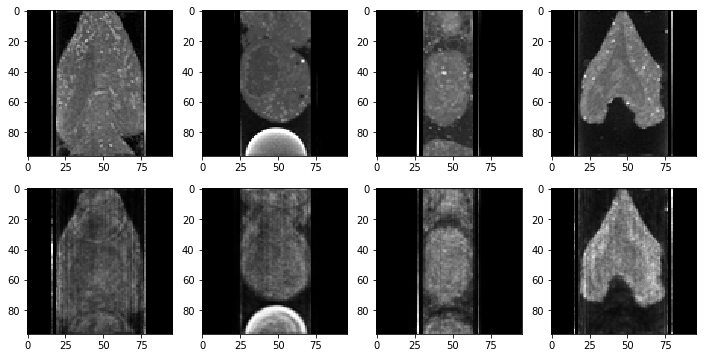

In [14]:
num = 4
# reconstruct images - AE only
idx = np.random.randint(len(X_flat),size=num)
pred = model.predict([X_flat[idx],np.zeros((len(idx),1024))])

fig,ax = plt.subplots(ncols=num,nrows=2,figsize=(12,6))

for i in range(num):
    ax[0,i].imshow(X_flat[idx[i]].reshape(size,size),cmap='gray')
    ax[1,i].imshow(pred[i].reshape(size,size),cmap='gray')

plt.show()

In [15]:
Z = encoder.predict(X_flat)
Z_norm = (Z-Z.min())/(Z.max()-Z.min())

In [16]:
Z_norm.shape, Z.max(),Z.min()

((13786, 1024), 1.0000002, -1.0000002)

In [17]:
import numpy as np
import tensorflow as tf

from tensorflow.distributions import Normal
from tensorflow.distributions import Bernoulli

'''A Variational Auto Encoder using TensorFlow'''

class VariationalAutoencoder:
    
    def __init__(self, n_input, n_list, ent_weight = 1, lr=0.001):
        '''
        number of input neurons and a list of the number of neurons in the encoder hidden layers
            The last number provided should be the number of latent features desired
                
        The decoder will have an inverted architecture
        
        Note: the actual number of neurons in the last layer of the encoder will be x2, for mean and std
            '''
        # input data
        self.X = tf.placeholder(tf.float32, shape=(None, n_input))
        
        # encoder
        self.encoder_layers = []
        # input layer
        previous = n_input
        # in case there is only one hidden layer (for loop will be skipped)
        current = n_input
        # current is the output of each layer (skip last because there is nothing after it)
        for current in n_list[:-1]:
            h = DenseLayer(previous,current)
            self.encoder_layers.append(h)
            previous = current
        # latent features number
        latent = n_list[-1]
        encoder_output = DenseLayer(current,latent*2,activation='none')
        self.encoder_layers.append(encoder_output)
        
        # feed forward through encoder
        c_X = self.X
        for layer in self.encoder_layers:
            c_X = layer.feed_forward(c_X)
        # c_X now holds the output of the encoder
        # first half are the means
        self.means = c_X[:,:latent]
        # second half are the std; must be positive; +1e-6 for smoothing
        self.std = tf.nn.softplus(c_X[:,latent:]) + 1e-6
        
        # reparameterization trick
        normal = Normal(loc=self.means,scale=self.std)
        self.Z = normal.sample()
                
        # decoder
        self.decoder_layers = []
        previous = latent
        for current in reversed(n_list[:-1]):
            h = DenseLayer(previous,current)
            self.decoder_layers.append(h)
            previous = current
        # output is the reconstruction
        decoder_output = DenseLayer(previous,n_input,activation=lambda x:x)
        self.decoder_layers.append(decoder_output)

        #feed forward through decoder, using the sampled 'data'
        c_X = self.Z
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        # use logits for cost function below
        neg_cross_entropy = -tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X,
                    logits=logits)
        neg_cross_entropy = tf.reduce_sum(neg_cross_entropy, 1)
        
        # output
        self.y_prob = Bernoulli(logits=logits)
        
        # sample from output
        self.post_pred = self.y_prob.sample()
        self.post_pred_probs = tf.nn.sigmoid(logits)
        
        # generate 'de-novo' output
        self.gen = tf.Variable(0)
        Z_std = Normal(0.0,1.0).sample([self.gen,latent])
        c_X = Z_std
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        
        prior_pred_dist = Bernoulli(logits=logits)
        self.prior_pred = prior_pred_dist.sample()
        self.prior_pred_probs = tf.nn.sigmoid(logits)
        
        # manually input Z
        self.Z_input = tf.placeholder(np.float32, shape=(None, latent))
        c_X = self.Z_input
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        self.manual_prior_prob = tf.nn.sigmoid(logits)
        
        # cost function
        # Kullback–Leibler divergence
        kl = -tf.log(self.std) + 0.5*(self.std**2 + self.means**2) - 0.5
        kl = tf.reduce_sum(kl, axis=1)
        # ELBO
        self.elbo = tf.reduce_sum(ent_weight * neg_cross_entropy - kl)
        
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(-self.elbo)
               
        self.init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(self.init)
        
    def fit(self,X,epochs=10,batch=50):
        n_batches = len(X) // batch
        for epoch in range(epochs):
            print('Epoch:',epoch+1)
            np.random.shuffle(X)
            cost = 0
            for b in range(n_batches):
                c_batch = X[b*batch:(b+1)*batch]
                _,c, = self.session.run((self.optimizer, self.elbo),feed_dict={self.X: c_batch})
                # accumulate cost
                cost+=c
            print('Cost:', cost)
            
    def predict(self,X,out='prob'):
        '''
        Pass data through encoder and decoder and retrieve reconstructed output
            by default the probabilities are returned, user can specify 'sample' or 'both'
        '''
        # correct shape if needed
        if (X.ndim==1):
            X = X.reshape([1,-1])
        pred,prob = self.session.run((self.post_pred,self.post_pred_probs),feed_dict={self.X:X})
        if (out=='prob'):
            return prob
        elif (out=='sample'):
            return pred
        else:
            return pred,prob

    def generate(self,n=1,out='prob'):
        '''
        Generate output
            by default the probabilities are returned, user can specify 'sample' or 'both'
            User specifies the number of points requested 
        '''
        pred,prob = self.session.run((self.prior_pred,self.prior_pred_probs),feed_dict={self.gen:n})
        if (out=='prob'):
            return prob
        elif (out=='sample'):
            return pred
        else:
            return pred,prob
    
    def feed(self,Z):
        '''Generate output using provided latent-space input Z'''
        # correct shape if needed
        if (Z.ndim==1):
            Z = Z.reshape([1,-1])
        return self.session.run(self.manual_prior_prob,feed_dict={self.Z_input:Z})
    
    def close(self):
        self.session.close()

class DenseLayer(object):
    '''A fully connected layer'''
    
    def __init__(self, n_in, n_out, activation=tf.nn.relu):
        '''number of input and output neurons; the activation function'''
        self.weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), stddev=2/np.sqrt(n_in)))
        self.bias = tf.Variable(tf.constant(0.0,shape=[n_out]))
        if (activation=='none'):
            self.activation = lambda x: x
        else:
            self.activation = activation
            
    def feed_forward(self, X):
        '''Run input through layer and retrieve output'''
        return self.activation(tf.matmul(X, self.weights) + self.bias)

In [25]:
vae = VariationalAutoencoder(1024,[256,32],ent_weight=1)

In [26]:
vae.fit(Z_norm,epochs=10,batch=5)

Epoch: 1
Cost: -3256308.221801758
Epoch: 2
Cost: -2673523.494873047
Epoch: 3
Cost: -2516642.7064819336
Epoch: 4
Cost: -2424115.915222168
Epoch: 5
Cost: -2358552.799194336
Epoch: 6
Cost: -2306201.9259033203
Epoch: 7
Cost: -2266433.0346069336
Epoch: 8
Cost: -2236557.888244629
Epoch: 9
Cost: -2216873.5560913086
Epoch: 10
Cost: -2203200.937072754


In [27]:
pred = vae.predict(Z_norm)
Z_prime = pred * (Z.max()-Z.min()) + Z.min()
reconstructed = decoder.predict([Z_prime,np.zeros(shape=(len(pred),size**2))])

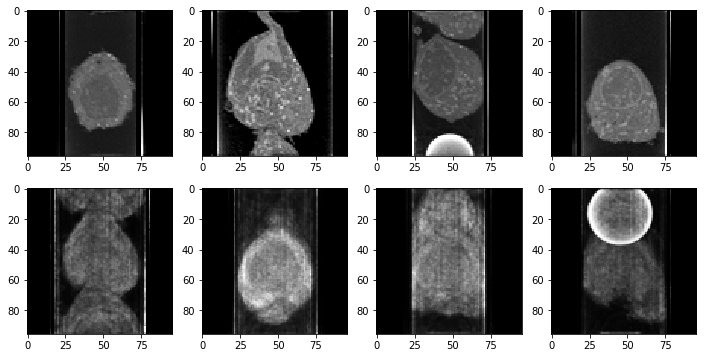

In [28]:
num = 4
# reconstruct images through the AE and VAE
idx = np.random.randint(len(X_flat),size=num)

fig,ax = plt.subplots(ncols=num,nrows=2,figsize=(12,6))

for i in range(num):
    ax[0,i].imshow(X_flat[idx[i]].reshape(size,size),cmap='gray')
    ax[1,i].imshow(reconstructed[idx[i]].reshape(size,size),cmap='gray')

plt.show()

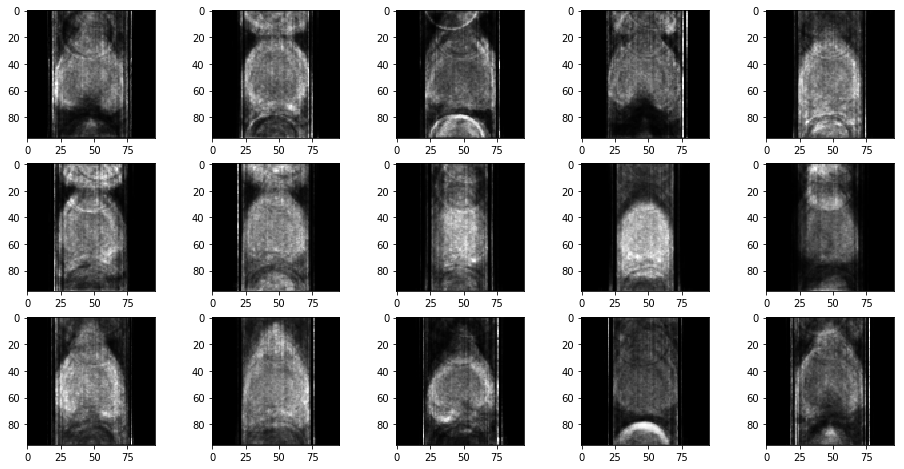

In [29]:
# generate novel images
n = 5
r = 3
genN = vae.generate(n*r)

gen_prime = genN * (Z.max()-Z.min()) + Z.min()
reconstructed = decoder.predict([gen_prime,np.zeros(shape=(len(gen_prime),size**2))])

fig,ax = plt.subplots(ncols=n,nrows=r,figsize=(16,8))

for i in range(n):
    for j in range(r):
        ax[j,i].imshow((reconstructed[i+j*n].reshape(size,size)),cmap='gray')
    
plt.show()